In [1]:
%matplotlib inline
import pickle
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

In [2]:
def extract_period(yrs, series, fyr=1971.5, lyr=2018.5):
    """
    This function extracts a subsection of a timeseries on the basis of specified first and last years
    inputs:
        * yrs    = time coordinate in years
        * series = input timeseries
        * fyr    = first year of sub-period
        * lyr    = last year of sub-period
    outputs:
        * subyrs    = years corresponding to sub-section timeseries
        * subseries = sub-section of input timeseries
    """
    subi = np.where((yrs >= fyr) & (yrs <= lyr))[0]  # Index for sub-section
    subseries = series[subi].copy()
    subyrs = yrs[subi]
    return subyrs, subseries


def runningmean(yrs, series, window=3):
    """
    This function applies a running-mean smoothing to OHC timerseries in order to reduce the effect
    of sampling noise. The default is to use a 3-yr window, following Domingues et al (2008) and AR6
    Chapter 2.
    :param yrs: input time coordinate in years
    :param series: input timeseries
    :param window: the length of the window for running-mean
    :return: timeseries with running-mean applied, with same length as original timeseries
    """
    newseries = series.copy()
    # First extract the non-NaN values into a sub-array
    nmsgi = np.isfinite(series)
    subseries = series[nmsgi]
    subyrs    = yrs[nmsgi]
    # Perform the runnning mean..
    weights = np.repeat(1.0, window)/window
    rmseries = np.convolve(subseries, weights, 'same') # Preserve original series length (end effects visible)
    rmseries[0] = subseries[0] # Make sure the start and end points are identical to original series (avoid edge effects)
    rmseries[-1] = subseries[-1]
    # Reinstate the rmseries into the parent array copy..
    newseries[nmsgi] = rmseries
    return newseries

def read_AR6_gmsl(datadir='./data/',
                  filename='AR6_GMSL_ensemble_FGD.csv', key1='Central Estimate', 
                  key2='Total Unc. (1-sigma)', skip=2):
    f = open(datadir + filename, "r")
    lines = f.readlines()
    header = lines[skip - 1].strip('\n')
    keys = header.split(",")
    f.close()
    ncols = len(lines[-1].split(","))  # Get number of columns from the last line..
    nrows = len(lines) - skip  # Get number of data lines in text file
    data = np.zeros([nrows, ncols])  # Convention of rows then columns for Numpy arrays (?)
    for jj in range(nrows):
        for ii in range(ncols):
            data[jj, ii] = float(lines[jj + skip].split(",")[ii])
    data_dict = dict.fromkeys(keys)
    for kk, key in enumerate(keys):
        data_dict[key] = data[:, kk]
        
    yrs = data_dict['Year']
    series = data_dict[key1]
    error  = data_dict[key2]
        
    return yrs, series, error

    
def combine_TG_altimeter(tg_yrs, tg_series, tg_errors, alt_yrs, alt_series, alt_errors, fyr=1901.5, lyr=2019.5, splice=False):
    """
    This function combines the tide gauge and altimeter timeseries and computes the 
    uncertainty in delta-GMSL relative to the first year of the timeseries. 
    """
    # Combined tide gauge and altimeter timeseries: 
    gmsl_yrs = np.arange(fyr, lyr+1, 1.0)
    gmsl_series = np.empty(len(gmsl_yrs))
    gmsl_errors = np.empty(len(gmsl_yrs))

    tmi = np.where((tg_yrs >= fyr) & (tg_yrs <= 1992.5))
    ami = np.where((alt_yrs >= 1993.5) & (alt_yrs <= lyr))
    gi1 = np.where((gmsl_yrs >= fyr ) & (gmsl_yrs <= 1992.5))
    gi2 = np.where((gmsl_yrs >= 1993.5) & (gmsl_yrs <= lyr))
    
    if splice == True: # Splice the timeseries, set start of Altimeter series to Tide gauge value at 1993
        ind1 = np.where(tg_yrs == 1993.5)[0]
        ind2 = np.where(alt_yrs == 1993.5)[0]
        offset = tg_series[ind1] - alt_series[ind2]
        alt_series = alt_series + offset

    gmsl_series[gi1] = tg_series[tmi]
    gmsl_series[gi2] = alt_series[ami]
    gmsl_errors[gi1] = tg_errors[tmi]
    gmsl_errors[gi2] = alt_errors[ami]
    
                              
    return gmsl_yrs, gmsl_series, gmsl_errors

In [3]:
datadir = './data/'
#pfile   = 'AR6_energy_GMSL_timeseries_FGD_1971to2018.pickle'
pfile   = 'AR6_energy_GMSL_timeseries_FGD_1971to2018_corrigendum.pickle' # Include IMBIE update from 10.03.21
plotdir = '../PNGs/'
plotfile1 = 'CCBox9.1_Figure1_FGD_18x9cm_corrigendum.png'
plotfile2 = 'CCBox9.1_Figure1_FGD_18x9cm_corrigendum.pdf'

# Specify start and end year of period
fyr=1971.5
lyr=2018.5
pstr = str(int(fyr)) + '-' + str(int(lyr)) # period as a string

plotdir = '../PNGs/'

data = pickle.load( open( datadir + pfile, 'rb' ) )

energy_dict = data['energy_dict']
gmsl_dict = data['gmsl_dict']

eyrs = energy_dict['yrs']
syrs = gmsl_dict['yrs']

Eseries  = energy_dict['Total']
Eerror   = energy_dict['Total_error']
SLseries  = gmsl_dict['Total']
SLerror   = gmsl_dict['Total_error']

# Compute total delta and uncertainty for the period 1971-2018
delE  = Eseries[-1] - Eseries[0]
delSL = SLseries[-1] - SLseries[0]
errE  = np.sqrt(Eerror[0]**2 + Eerror[-1]**2) * 1.645 # Express as very likley range, i.e. 1.645 * sigma
errSL = np.sqrt(SLerror[0]**2 + SLerror[-1]**2) * 1.645 # Express as very likley range, i.e. 1.645 * sigma

print(pstr + ' Energy change (ZJ) = {0:5.1f} [{1:5.1f} to {2:5.1f}]'.format(delE, delE - errE, delE + errE))
print(pstr + ' GMSL change (mm) = {0:5.1f} [{1:5.1f} to {2:5.1f}]'.format(delSL, delSL - errSL, delSL + errSL) + ' (sum of components)')

1971-2018 Energy change (ZJ) = 434.9 [324.5 to 545.3]
1971-2018 GMSL change (mm) =  94.2 [ 71.5 to 117.0] (sum of components)


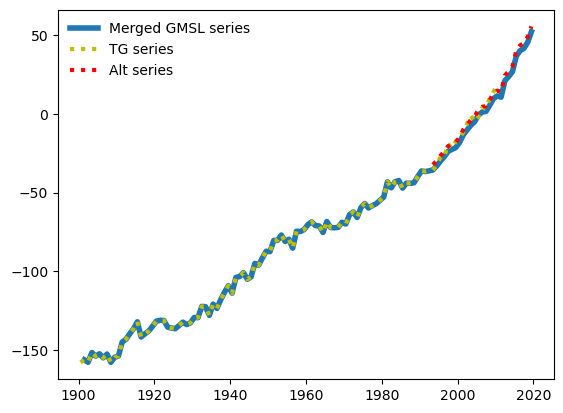

1971-2018 GMSL change (mm) = 109.6 [ 72.8 to 146.4] (tide gauge/altimeter)


In [4]:
# Read in the data and combine the timeseries.. 
tyrs, tseries, terrors = read_AR6_gmsl()
ayrs, aseries, aerrors  = read_AR6_gmsl(filename='AR6_GMSL_altimeter_FGD.csv', key2='Uncertainty (1-sigma)')
GMSLyrs, GMSLseries, GMSLerrors = combine_TG_altimeter(tyrs, tseries, terrors, ayrs, aseries, aerrors, splice=True)

# Note that "splice" is needed to ensure total matches the combined deltas for tide gauge and altimeter. 
# The slight mis-match is because the individual timeseries are referenced to 1995-2014 period. 
plt.plot(GMSLyrs, GMSLseries, linewidth=4.0, label='Merged GMSL series')
plt.plot(tyrs, tseries, 'y:',linewidth=3.0, label='TG series')
plt.plot(ayrs, aseries, 'r:',linewidth=3.0, label='Alt series')
plt.legend(loc='upper left', frameon=False)
plt.show()

# Compute total delta and uncertainty for the period 1971-2018
ind1 = np.where(tyrs == fyr)[0][0]
ind2 = np.where(tyrs == 1993.5)[0][0]
ind3 = np.where(ayrs == 1993.5)[0][0]
ind4 = np.where(ayrs == lyr)[0][0]

delta1 = tseries[ind2] - tseries[ind1]
delta2 = aseries[ind4] - aseries[ind3]
unc1 = np.sqrt(terrors[ind1]**2 + terrors[ind2]**2) # Uncertainty for tide gauge period
unc2 = np.sqrt(aerrors[ind3]**2 + aerrors[ind4]**2) # Uncertainty for altimeter period 

delGMSL = delta1 + delta2 
errGMSL = np.sqrt(unc1**2 + unc2**2) * 1.645 # Express as very likley range, i.e. 1.645 * sigma
print(pstr + ' GMSL change (mm) = {0:5.1f} [{1:5.1f} to {2:5.1f}]'.format(delGMSL, delGMSL - errGMSL, delGMSL + errGMSL) + ' (tide gauge/altimeter)')

Saving file:  ../PNGs/CCBox9.1_Figure1_FGD_18x9cm_corrigendum.png
Saving file:  ../PNGs/CCBox9.1_Figure1_FGD_18x9cm_corrigendum.pdf


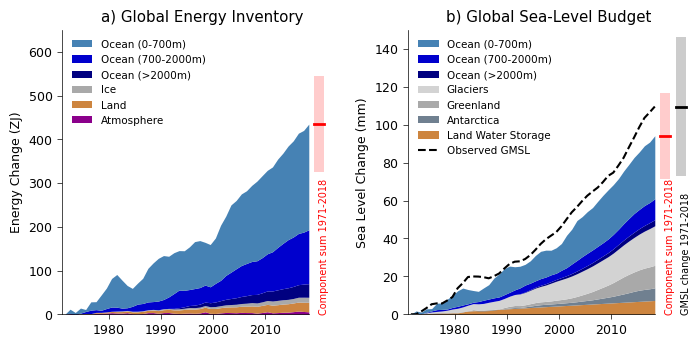

In [5]:
# Plot Cross-Chapter Box 9.1 Figure 1 

alpha = 0.2 # Set transparency parameter

e_comps = ['atmosphere', 'land', 'cryosphere', 
           'ocean_>2000m', 'ocean_700-2000m', 'ocean_0-700m']

sl_comps = ['landwater','antarctica', 'greenland', 'glaciers',
            'ocean_>2000m', 'ocean_700-2000m', 'ocean_0-700m']

plt.figure(1)
f = plt.gcf()
# Set dimensions to 18 x 9 cm.. = 7.086 x 3.543 inces
f.set_size_inches(7.086, 3.543)
matplotlib.rcParams['font.size']=9
matplotlib.rcParams['axes.linewidth']=0.5 # set the value globally

yrs = gmsl_dict['yrs']

#xmin, xmax = yrs[0], yrs[-1]
xmin, xmax = 1971, 2025
hcmin, hcmax = 0.0, 650.
slmin, slmax = 0.0, 150.

color_dict = {'atmosphere':'darkmagenta',
              'seaice':'silver',
              'cryosphere':'darkgrey',
              'landwater':'peru',
              'land':'peru',
              'antarctica':'slategrey',
              'greenland':'darkgrey',
              'glaciers':'lightgray', 
              'ocean_0-700m':'steelblue', 
              'ocean_700-2000m':'mediumblue',
              'ocean_700-2000m_ishii':'mediumblue',
              'ocean_0-2000m':'mediumblue',
              'ocean_full-depth':'mediumblue', 
              'ocean_>2000m':'navy',
              'tidegauge':'k', 
              'component_sum':'r',
              'energy_error':'r'}

label_dict = {'atmosphere':'Atmosphere',
              'seaice':'Sea ice',
              'cryosphere':'Ice',
              'landwater':'Land Water Storage',
              'land':'Land',
              'antarctica':'Antarctica',
              'greenland':'Greenland',
              'glaciers':'Glaciers', 
              'ocean_0-700m':'Ocean (0-700m)', 
              'ocean_700-2000m':'Ocean (700-2000m)',
              'ocean_700-2000m_ishii':'Ocean (700-2000m)',
              'ocean_0-2000m':'Ocean (0-2000m)',
              'ocean_full-depth':'Ocean', 
              'ocean_>2000m':'Ocean (>2000m)',
              'gmsl':'GMSL total', 
              'Total':'Component total'}

ax1 = plt.subplot(1, 2, 1)
series = np.zeros(len(yrs)) # Initialise empty time series for plotting

for cc, comp in enumerate(e_comps):
    label = label_dict[comp]
    newseries = series + energy_dict[comp]
    plt.fill_between(yrs, series, newseries, color=color_dict[comp], label=label, linewidth=0.0)
    series = newseries

# Plot the total delta and uncertainty for Energy change on RHS of timeseries..    
xcrd  = 2020.5
xpts = [xcrd-1, xcrd+1]
color = color_dict['energy_error']
plt.fill_between(xpts, [delE-errE, delE-errE], [delE+errE, delE+errE], facecolor=color, alpha=alpha)
plt.plot(xpts, [delE, delE], linewidth=2.0, color=color)
text = 'Component sum 1971-2018'
plt.text(xcrd, hcmin, text, horizontalalignment='left', verticalalignment='bottom', 
         rotation=90., color=color, fontsize=7.0)
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(reversed(handles), reversed(labels), loc='upper left', frameon=False, fontsize=7.5)    
ax1.set_title('a) Global Energy Inventory')
ax1.set_ylabel('Energy Change (ZJ)')
#ax1.set_xlabel('Year')
ax1.set_xlim(xmin, xmax)
ax1.set_xticks([1980., 1990., 2000., 2010.])
ax1.set_ylim(hcmin, hcmax)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_bounds(low=1971,high=2018.5)
ax1.tick_params(width=0.5)
    
ax2 = plt.subplot(1, 2, 2)
series = np.zeros(len(yrs)) # Initialise empty time series for plotting

for cc, comp in enumerate(sl_comps):
    label = label_dict[comp]
    newseries = series + gmsl_dict[comp]
    plt.fill_between(yrs, series, newseries, color=color_dict[comp], label=label, linewidth=0.0)
    series = newseries
SL_total = newseries


# Plot the total delta and uncertainty for sum of component change on RHS of timeseries.. 
cc=0
color = color_dict['component_sum']
xpts = [xcrd-1, xcrd+1]
plt.fill_between(xpts, [delSL-errSL, delSL-errSL], [delSL+errSL, delSL+errSL], facecolor=color, alpha=alpha)
plt.plot(xpts, [delSL, delSL], linewidth=2.0, color=color)
text = 'Component sum 1971-2018'
plt.text(xcrd, slmin, text, horizontalalignment='left', verticalalignment='bottom', 
         rotation=90., color=color, fontsize=7.0)

# Plot the delta and uncertainty for observed GMSL change on RHS of timeseries.. 
comp = 'gmsl'
color = 'k'
cc = 1
xcrd  = cc*3 + 2020.5
xpts = [xcrd-1, xcrd+1]
plt.fill_between(xpts, [delGMSL-errGMSL, delGMSL-errGMSL], [delGMSL+errGMSL, delGMSL+errGMSL], facecolor=color, alpha=alpha)
plt.plot(xpts, [delGMSL, delGMSL], linewidth=2.0, color=color)
text = 'GMSL change 1971-2018'
plt.text(xcrd, slmin, text, horizontalalignment='left', verticalalignment='bottom', 
         rotation=90., color=color, fontsize=7.0)


yrs, series = extract_period(GMSLyrs, GMSLseries) # Extract 1971-2018 period 
series -= series[0] # Plot timeseries relative to 1971 value. 
smseries = runningmean(yrs, series) # Apply 3-yr smoothing to timeseries

#ax2.plot(yrs, series, 'k--', label='Observed GMSL') # Plot unsmoothed timeseries 
ax2.plot(yrs, smseries, 'k--', label='Observed GMSL') # Option to plot 3-yr smoothed timeseries instead. 
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(reversed(handles), reversed(labels), loc='upper left', frameon=False, fontsize=7.5)
ax2.set_title('b) Global Sea-Level Budget')
ax2.set_ylabel('Sea Level Change (mm)')
#ax2.set_xlabel('Year')
ax2.set_xlim(xmin, xmax)
ax2.set_ylim(slmin, slmax)
ax2.set_xticks([1980., 1990., 2000., 2010.])
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_bounds(low=1971,high=2018.5)
ax2.tick_params(width=0.5)

plt.tight_layout()

print("Saving file: ", plotdir+plotfile1)
print("Saving file: ", plotdir+plotfile2)
plt.savefig(plotdir+plotfile1, dpi=300, format='png')
plt.savefig(plotdir+plotfile2, dpi=300, format='pdf')
plt.show()
plt.close(1)
